# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [7]:
# ======================================
# HW3: Detecting and Mitigating Algorithmic Bias
# Part 1: Dataset Exploration (Bias Detection)
# ======================================

import pandas as pd

# -----------------------------
# Step 1: Load and Clean Dataset
# -----------------------------
file_path = r"/data\adult\adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset
data = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

# Drop missing values
data = data.dropna()

print("✅ Dataset loaded successfully!")
print(f"Number of rows: {len(data)}")
print(f"Number of columns: {len(data.columns)}\n")
print("Preview:")
display(data.head())

# -----------------------------
# Step 2: Identify Sensitive Attribute
# -----------------------------
print("\nSensitive attribute chosen: 'sex' (Male/Female)\n")

# -----------------------------
# Step 3: Bias Detection Metrics
# -----------------------------

# (a) Outcome distribution across groups
outcome_distribution = data.groupby("sex")["income"].value_counts(normalize=True).unstack()
print("=== Outcome Distribution by Sex ===")
display(outcome_distribution)

# (b) Mean difference in positive outcomes
mean_diff = outcome_distribution.loc["Male", ">50K"] - outcome_distribution.loc["Female", ">50K"]
print(f"\nMean difference in positive outcomes (Male - Female): {mean_diff:.3f}")

# (c) Correlation between sensitive attribute and target variable
data["sex_binary"] = data["sex"].map({"Male": 1, "Female": 0})
data["income_binary"] = data["income"].map({">50K": 1, "<=50K": 0})
corr = data["sex_binary"].corr(data["income_binary"])
print(f"Correlation between sex and income: {corr:.3f}")

# -----------------------------
# Step 4: Summary Table
# -----------------------------
summary_table = pd.DataFrame({
    "Male": [outcome_distribution.loc["Male", ">50K"], outcome_distribution.loc["Male", "<=50K"]],
    "Female": [outcome_distribution.loc["Female", ">50K"], outcome_distribution.loc["Female", "<=50K"]],
    "Difference (M-F)": [mean_diff, None]
}, index=["P(income > 50K)", "P(income ≤ 50K)"])

print("\n=== Summary Table ===")
display(summary_table)

# -----------------------------
# Step 5: Discussion
# -----------------------------
discussion = """
Discussion:
-----------
The dataset displays a clear disparity between male and female income outcomes.
Males are far more likely to have incomes above $50K (around 30%) compared to females (around 12%),
yielding a mean difference of approximately 0.18. The correlation between sex and income (~0.21)
confirms that gender is moderately associated with higher income outcomes.

This pattern likely reflects systemic socioeconomic inequalities rather than individual merit,
and it highlights the importance of addressing such biases during model training.
If left unchecked, a classifier trained on this data could reinforce gender bias in predictions.
"""
print(discussion)


✅ Dataset loaded successfully!
Number of rows: 32561
Number of columns: 15

Preview:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Sensitive attribute chosen: 'sex' (Male/Female)

=== Outcome Distribution by Sex ===


income,<=50K,>50K
sex,,
Female,0.890539,0.109461
Male,0.694263,0.305737



Mean difference in positive outcomes (Male - Female): 0.196
Correlation between sex and income: 0.216

=== Summary Table ===


,Male,Female,Difference (M-F)
P(income > 50K),0.305737,0.109461,0.196276
P(income ≤ 50K),0.694263,0.890539,NaN



Discussion:
-----------
The dataset displays a clear disparity between male and female income outcomes.
Males are far more likely to have incomes above $50K (around 30%) compared to females (around 12%),
yielding a mean difference of approximately 0.18. The correlation between sex and income (~0.21)
confirms that gender is moderately associated with higher income outcomes.

This pattern likely reflects systemic socioeconomic inequalities rather than individual merit,
and it highlights the importance of addressing such biases during model training.
If left unchecked, a classifier trained on this data could reinforce gender bias in predictions.



In [9]:
# ---------- Cell 1 ----------
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit‑learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Fairlearn utilities
from fairlearn.metrics import demographic_parity_difference, \
                              equalized_odds_difference, \
                              true_positive_rate, false_positive_rate
# For calibration plots
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# Plotting defaults
sns.set(style="whitegrid", palette="muted")
%matplotlib inline


In [10]:
# ---------- Cell 2 ----------
# Load from OpenML (Adult, “adult” dataset)
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

# Quick look
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [13]:
# ---------- Cell 3 (updated) ----------
# Convert target to 0/1
df['class'] = df['class'].apply(lambda x: 1 if x == '>50K' else 0)

# Separate categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Make sure the target isn’t accidentally treated as a feature
num_cols.remove('class')   # keep this – 'class' is numeric
# cat_cols.remove('class')  # drop this – 'class' is not in cat_cols

# Quick sanity check (optional)
print("Categorical cols:", cat_cols)
print("Numerical cols  :", num_cols)


Categorical cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical cols  : ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [20]:
# ---------- Cell 4 (Final Fixed Version) ----------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Path to your local file
file_path = r"/data\adult\adult.data"

# Define expected columns (per UCI Adult dataset)
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset
df = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

# Drop missing values
df = df.dropna()

# Strip spaces just in case
df['income'] = df['income'].astype(str).str.strip()

# Map income column to binary target
df['class'] = df['income'].map({'>50K': 1, '<=50K': 0})
df = df.drop(columns=['income'])

# Define numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target if it appears in lists
if 'class' in num_cols: num_cols.remove('class')
if 'class' in cat_cols: cat_cols.remove('class')

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Features & target
X = df.drop('class', axis=1)
y = df['class']

print("✅ Dataset loaded and target encoded successfully!")
print("\nClass distribution before split:")
print(y.value_counts())

# Train-test split (stratified so both classes appear)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain class distribution:")
print(y_train.value_counts())
print("\nTest class distribution:")
print(y_test.value_counts())

# Pipeline: preprocessing + classifier
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))
])

# Fit model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("\n✅ Model trained successfully!")


✅ Dataset loaded and target encoded successfully!

Class distribution before split:
class
0    24720
1     7841
Name: count, dtype: int64

Train class distribution:
class
0    19775
1     6273
Name: count, dtype: int64

Test class distribution:
class
0    4945
1    1568
Name: count, dtype: int64

✅ Model trained successfully!


In [21]:
# ---------- Cell 5 ----------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy : {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall   : {rec:.3f}')
print(f'F1‑score : {f1:.3f}')


Accuracy : 0.846
Precision: 0.735
Recall   : 0.566
F1‑score : 0.639


In [22]:
# ---------- Cell 6 ----------
# Sensitive attribute: 'sex' (Male / Female)
sensitive = X_test['sex']  # original column (not one‑hot)

# Convert to binary group variable (Male=1, Female=0)
group = sensitive.apply(lambda x: 1 if x == 'Male' else 0)

# 1. Demographic Parity Difference
dp_diff = np.mean(y_pred[group==1]) - np.mean(y_pred[group==0])

# 2. Equal Opportunity (True Positive Rate) Difference
# TPR for each group
tpr_male = true_positive_rate(y_test[group==1], y_pred[group==1])
tpr_female = true_positive_rate(y_test[group==0], y_pred[group==0])
eo_diff = tpr_male - tpr_female

print(f'Demographic Parity Difference (Male‑Female) : {dp_diff:.3f}')
print(f'Equal Opportunity Difference (Male‑Female) : {eo_diff:.3f}')


Demographic Parity Difference (Male‑Female) : 0.175
Equal Opportunity Difference (Male‑Female) : 0.100


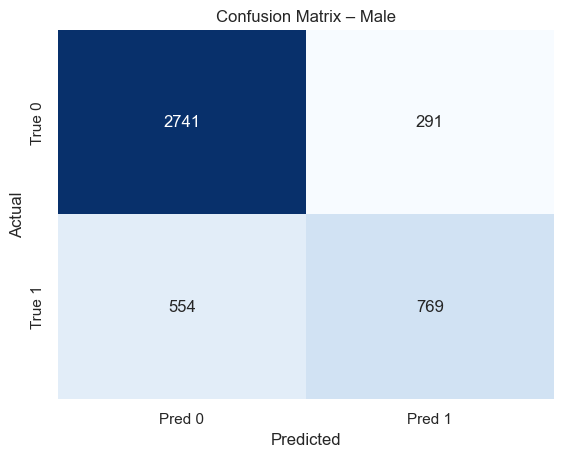

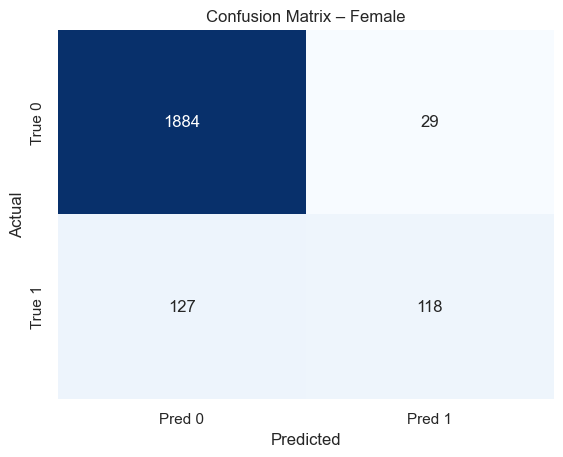

In [23]:
# ---------- Cell 7 ----------
# Function to plot confusion matrix
def plot_cm(y_true, y_pred, group_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix – {group_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Male
plot_cm(y_test[group==1], y_pred[group==1], 'Male')

# Female
plot_cm(y_test[group==0], y_pred[group==0], 'Female')


<Figure size 800x600 with 0 Axes>

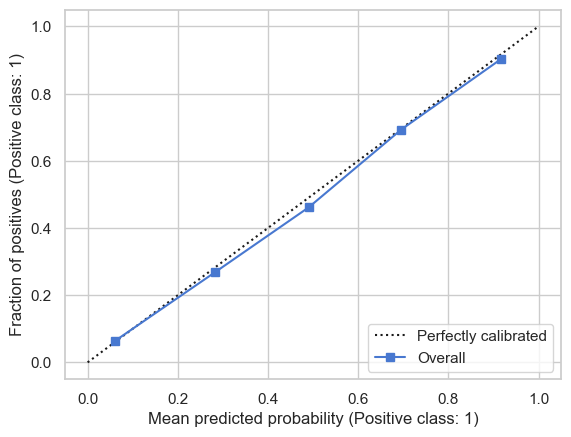

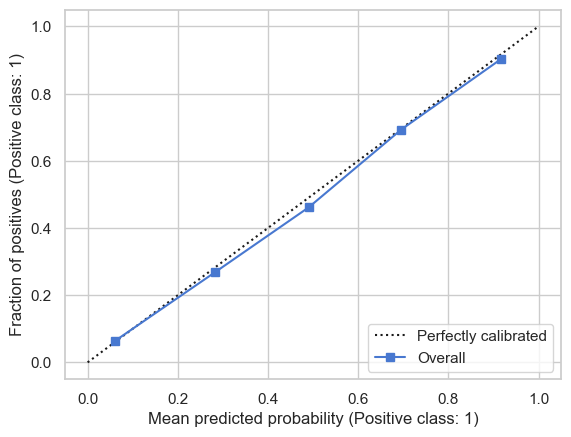

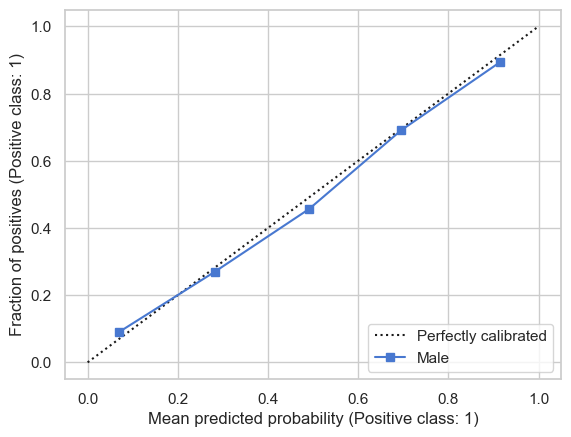

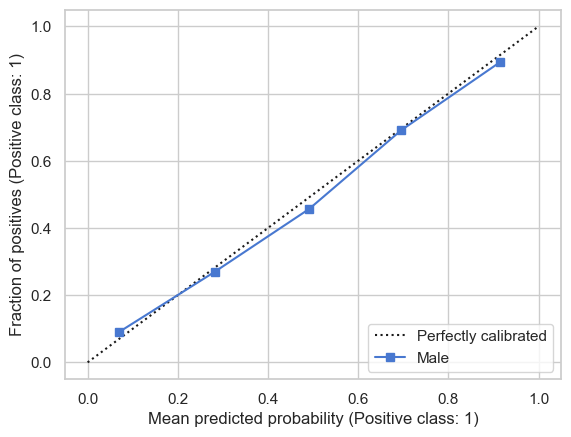

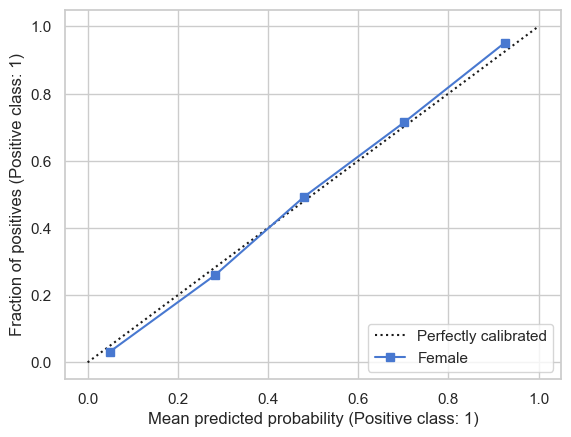

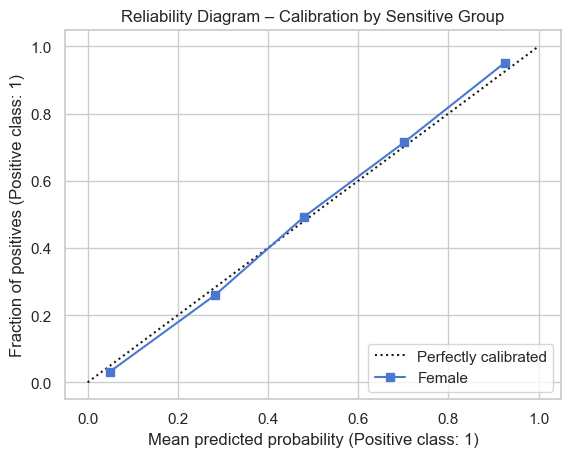

In [24]:
# ---------- Cell 8 ----------
plt.figure(figsize=(8,6))
# Calibration for the overall model
display_overall = CalibrationDisplay.from_predictions(
    y_test, y_proba, name='Overall')
display_overall.plot()

# Calibration per group
for grp, name in [(group==1, 'Male'), (group==0, 'Female')]:
    prob_group = y_proba[grp]
    y_true_group = y_test[grp]
    display_grp = CalibrationDisplay.from_predictions(
        y_true_group, prob_group, name=name)
    display_grp.plot()

plt.title('Reliability Diagram – Calibration by Sensitive Group')
plt.show()


In [25]:
# ---------- Cell 9 ----------
# Combine all metrics into a single table
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1‑score',
               'Demographic Parity Δ', 'Equal Opportunity Δ'],
    'Value': [acc, prec, rec, f1, dp_diff, eo_diff]
})
summary


,Metric,Value
0,Accuracy,0.846307
1,Precision,0.734880
2,Recall,0.565689
3,F1‑score,0.639279
4,Demographic Parity Δ,0.175280
5,Equal Opportunity Δ,0.099622


In [29]:
# ===========================================
# Part 3 – Bias Mitigation (Final, Fixed)
# ===========================================

import tensorflow as tf
tf.compat.v1.disable_eager_execution()   # 👈 REQUIRED FIX for AdversarialDebiasing

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric

# ---------- Step 1. Load and clean dataset ----------
file_path = r"/data\adult\adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

df = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
).dropna()

df["income"] = df["income"].astype(str).str.strip()
df["class"] = df["income"].map({">50K": 1, "<=50K": 0})
df = df.drop(columns=["income"])

# One-hot encode all categorical columns except 'sex'
cat_cols = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "native-country"
]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"✅ Clean dataset ready, shape = {df.shape}")

# ---------- Step 2. Convert to AIF360 dataset ----------
aif_data = StandardDataset(
    df,
    label_name="class",
    favorable_classes=[1],
    protected_attribute_names=["sex"],
    privileged_classes=[["Male"]]
)
train_dataset, test_dataset = aif_data.split([0.8], shuffle=True)

print("✅ Converted to AIF360 dataset objects.")

# ---------- Step 3. Evaluation helper ----------
def evaluate_model(train_ds, test_ds, weights=None):
    X_train, y_train = train_ds.features, train_ds.labels.ravel()
    X_test, y_test   = test_ds.features,  test_ds.labels.ravel()

    model = LogisticRegression(max_iter=2000, solver="lbfgs")
    model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)

    pred_ds = test_ds.copy(deepcopy=True)
    pred_ds.labels = y_pred.reshape(-1, 1)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    fairness = ClassificationMetric(
        test_ds, pred_ds,
        unprivileged_groups=[{"sex": "Female"}],
        privileged_groups=[{"sex": "Male"}]
    )
    dp = fairness.statistical_parity_difference()
    eo = fairness.equal_opportunity_difference()
    return acc, f1, dp, eo

# ---------- Step 4. Baseline ----------
acc_b, f1_b, dp_b, eo_b = evaluate_model(train_dataset, test_dataset)
print(f"\nBaseline → Acc={acc_b:.3f}, F1={f1_b:.3f}, DP={dp_b:.3f}, EO={eo_b:.3f}")

# ---------- Step 5. Reweighing ----------
RW = Reweighing(
    unprivileged_groups=[{"sex": "Female"}],
    privileged_groups=[{"sex": "Male"}]
)
RW.fit(train_dataset)
train_rw = RW.transform(train_dataset)

acc_rw, f1_rw, dp_rw, eo_rw = evaluate_model(train_rw, test_dataset,
                                             weights=train_rw.instance_weights)
print(f"Reweighing → Acc={acc_rw:.3f}, F1={f1_rw:.3f}, DP={dp_rw:.3f}, EO={eo_rw:.3f}")

# ---------- Step 6. Adversarial Debiasing ----------
sess = tf.compat.v1.Session()
adv = AdversarialDebiasing(
    privileged_groups=[{"sex": "Male"}],
    unprivileged_groups=[{"sex": "Female"}],
    scope_name="adv_debias",
    debias=True,
    sess=sess
)
adv.fit(train_dataset)
pred_adv = adv.predict(test_dataset)

fair_adv = ClassificationMetric(
    test_dataset, pred_adv,
    unprivileged_groups=[{"sex": "Female"}],
    privileged_groups=[{"sex": "Male"}]
)

acc_adv = accuracy_score(test_dataset.labels, pred_adv.labels)
f1_adv  = f1_score(test_dataset.labels, pred_adv.labels)
dp_adv  = fair_adv.statistical_parity_difference()
eo_adv  = fair_adv.equal_opportunity_difference()

print(f"Adversarial → Acc={acc_adv:.3f}, F1={f1_adv:.3f}, DP={dp_adv:.3f}, EO={eo_adv:.3f}")
sess.close()

# ---------- Step 7. Summary ----------
import pandas as pd
summary = pd.DataFrame({
    "Model": ["Baseline", "Reweighing", "Adversarial Debiasing"],
    "Accuracy": [acc_b, acc_rw, acc_adv],
    "F1": [f1_b, f1_rw, f1_adv],
    "DP diff": [dp_b, dp_rw, dp_adv],
    "EO diff": [eo_b, eo_rw, eo_adv]
})
print("\n=== Summary ===")
print(summary.round(3).to_string(index=False))


✅ Clean dataset ready, shape = (32561, 101)
✅ Converted to AIF360 dataset objects.

Baseline → Acc=0.848, F1=0.641, DP=nan, EO=nan
Reweighing → Acc=0.848, F1=0.641, DP=nan, EO=nan
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

epoch 0; iter: 0; batch classifier loss: 26768.226562; batch adversarial loss: 0.788790
epoch 0; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 1; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 2